# Lab 2: The Very Basic Basics of Neural Networks

## Setup

In [1]:
"""
Computer Vision Course - Lab 2: Neural Networks

This cell sets up the environment.
Works automatically for both local and Google Colab!
"""

import os
import sys

# Detect environment
IN_COLAB = 'google.colab' in sys.modules

print("=" * 60)
print("Computer Vision - Lab 2 Setup")
print("=" * 60)

if IN_COLAB:
    print("\n🔵 Running on Google Colab")
    print("-" * 60)
    
    # Clone repository if not already present
    if not os.path.exists('computer-vision'):
        print("📥 Cloning repository...")
        !git clone https://github.com/mjck/computer-vision.git
        print("✓ Repository cloned successfully")
    else:
        print("✓ Repository already exists")
    
    # Navigate to lab directory
    %cd computer-vision/labs/lab02_neural_networks
    print(f"✓ Current directory: {os.getcwd()}")
    
    # Add repository root to Python path
    sys.path.insert(0, '/content/computer-vision')
    print("✓ Python path configured")
    
    print("-" * 60)
    print("🟢 Colab setup complete!\n")
    
else:
    print("\n🟢 Running locally")
    print("-" * 60)
    print(f"✓ Current directory: {os.getcwd()}")
    
    # Add repository root to Python path
    repo_root = os.path.abspath('../..')
    if repo_root not in sys.path:
        sys.path.insert(0, repo_root)
    print(f"✓ Repository root: {repo_root}")
    
    print("-" * 60)
    print("🟢 Local setup complete!\n")

print("=" * 60)
print("✅ Environment ready!")
print("=" * 60)

Computer Vision - Lab 2 Setup

🟢 Running locally
------------------------------------------------------------
✓ Current directory: /Users/gubscruz/INSPER/7_PERIODO/computer-vision/computer-vision/labs/lab02_neural_networks
✓ Repository root: /Users/gubscruz/INSPER/7_PERIODO/computer-vision/computer-vision
------------------------------------------------------------
🟢 Local setup complete!

✅ Environment ready!


## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import course utilities
from sdx import *

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

ModuleNotFoundError: No module named 'torch'

## Loading and Displaying the MNIST Dataset

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) is a famous dataset of handwritten digits.

Machine learning datasets consist basically of input-output pairs. Since our interest is computer vision, the inputs are naturally images, while the outputs depend on the problem. In this notebook, we consider a *classification* problem: each output is a *label* that indicates the *category* to which the image belongs.

It is recommended to separate these pairs in a set of *training data* and a set of *testing data,* because the goal is obtaining a model that works well with data that was *not* used for training.

The MNIST dataset already provides a separation. If that was not the case, we would have to obtain one. *(we will do this in later classes)*

In [4]:
# Download and load MNIST dataset
# PyTorch downloads to a 'data' folder by default
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Extract images and labels as numpy arrays for visualization
train_images = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

print(f"Training set: {len(train_images)} images")
print(f"Test set: {len(test_images)} images")
print(f"Image shape: {train_images[0].shape}")

Training set: 60000 images
Test set: 10000 images
Image shape: (28, 28)


The variable `train_images` is an array of 60000 images that should be used as training data. Below, we see the tenth image.

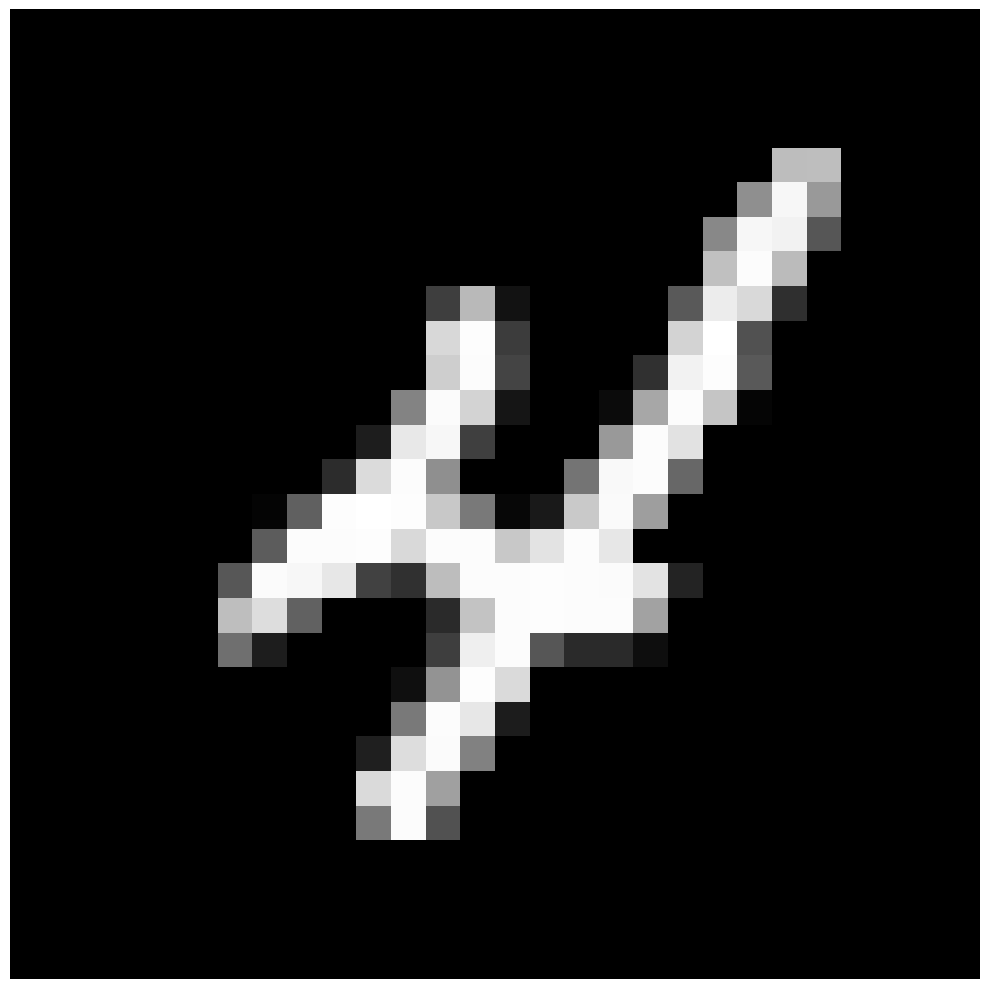

In [5]:
cv_imshow(train_images[9])

The variable `train_labels` is an array of 60000 integers, which are the respective labels of these images. These integers were obtained manually, so they are reliable to use as groundtruth. Below, we see the label of the tenth image.

In [6]:
train_labels[9]

np.int64(4)

The variable `test_images` is an array of 10000 images that should be used as testing data.

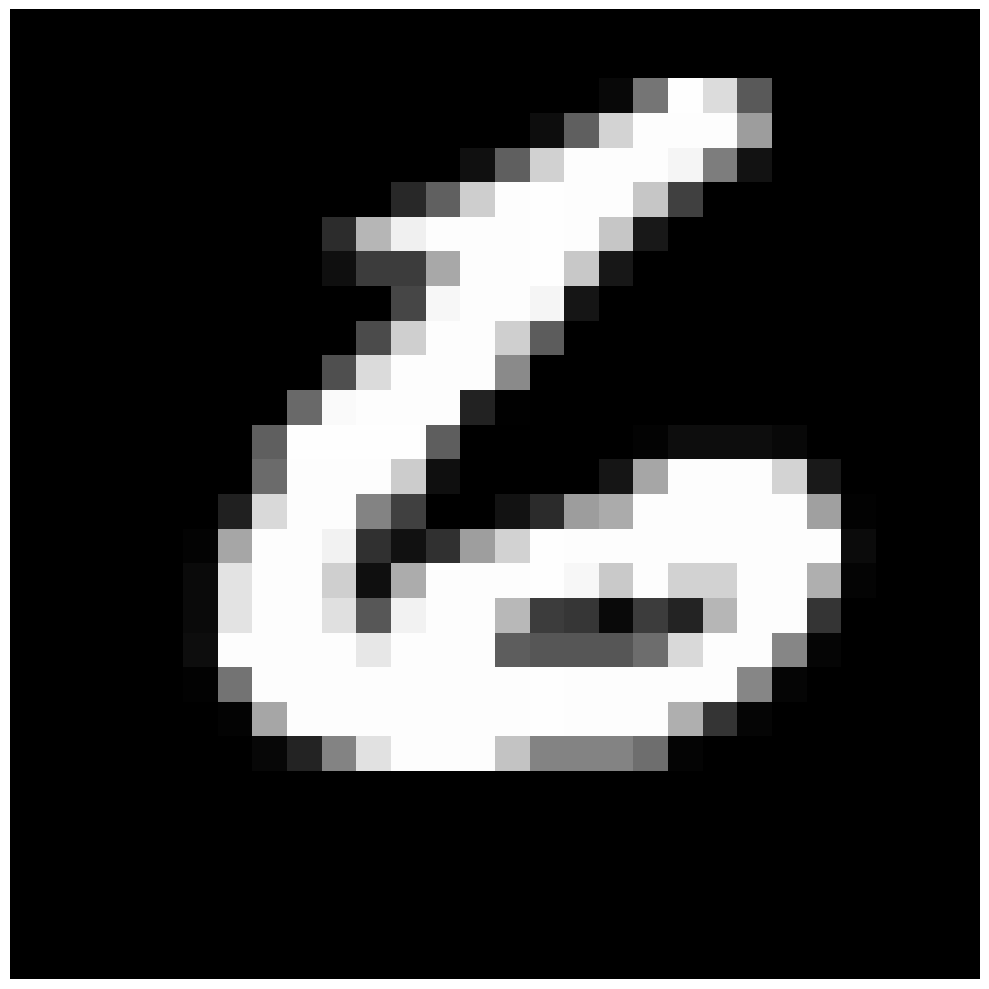

In [7]:
cv_imshow(test_images[-1])

Finally, the variable `test_labels` is an array of 10000 integers, which are its respective labels.

In [8]:
test_labels[-1]

np.int64(6)

To show more than one image at once, we can call the `cv_gridshow` function, passing the array and the parameters of a slice. Below, we show the 25 images that correspond to the `train_images[10:35]` slice.

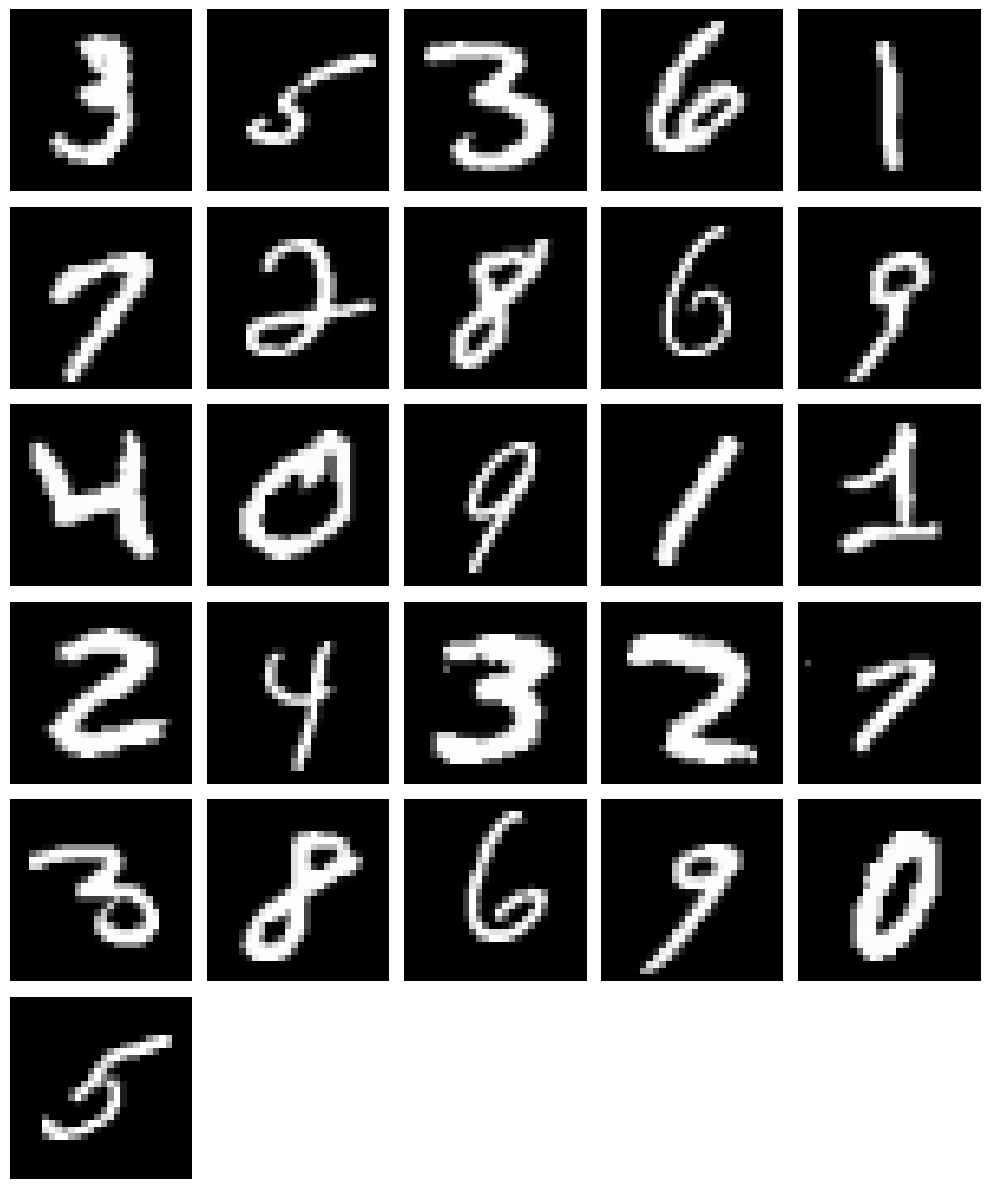

In [9]:
cv_gridshow(train_images, start=10, stop=35)

It is possible to show the labels alongside the images.

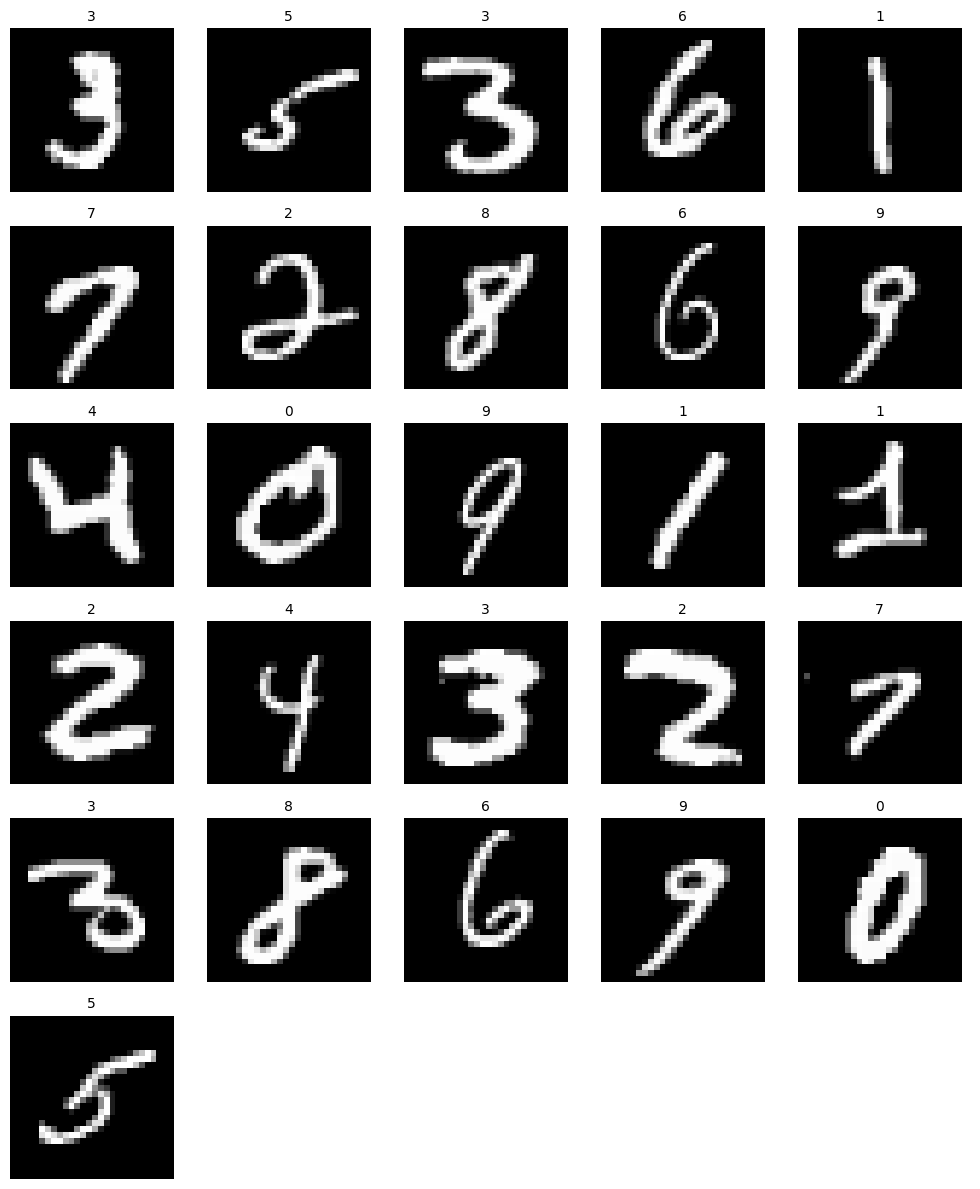

In [10]:
cv_gridshow(train_images, start=10, stop=35, labels=train_labels)

The default value for `start` is `0` and the default value for `stop` is `9`. This is important because the processing happens in Google servers but the rendering still happens in your machine. If you accidentally tried to show 60000 images at once, your browser would die horribly.

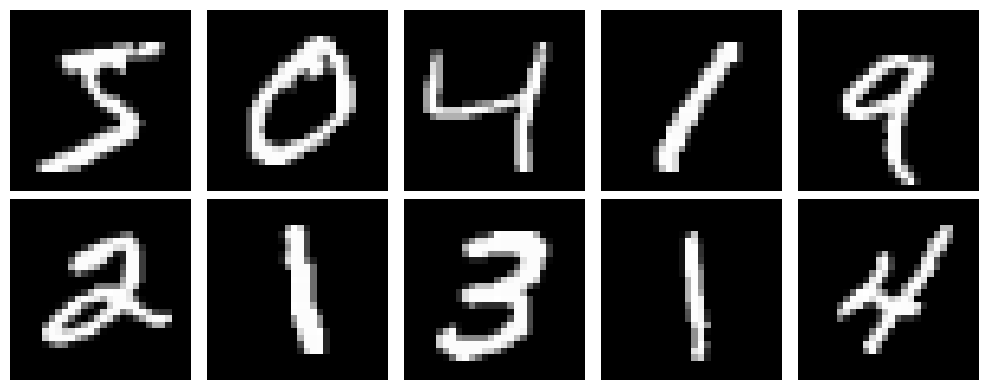

In [11]:
cv_gridshow(train_images)

## Building Neural Networks

Let's build a first neural network. More accurately, let's *demonstrate the foundations of building a neural network.* The actual model we will build is so trivial that we can't really call it an actual neural network, since it will have no hidden layers. *(we will properly discuss the concept of hidden layers in later classes)*

In [12]:
# Define a simple neural network in PyTorch
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Flatten layer is implicit in forward() method
        # Dense layer: 28*28 = 784 inputs -> 10 outputs
        self.fc = nn.Linear(28 * 28, 10)
    
    def forward(self, x):
        # Flatten the input: (batch, 28, 28) -> (batch, 784)
        x = x.view(x.size(0), -1)
        # Pass through dense layer
        x = self.fc(x)
        return x

# Create the model and move to device
model = SimpleNN().to(device)

print(model)

SimpleNN(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)


The code above defines a model with the following structure:

1. **Input**: Images with shape `(28, 28)` - the MNIST images have 28 rows, 28 columns, and only 1 color channel, since they are gray level images. *(as seen in the previous class)*

2. **Flatten**: The `view` operation in the `forward` method reshapes the 2D input tensors into 1D tensors by simply concatenating the rows. This is necessary because the next layer expects 1D tensors.

3. **Dense (Linear) layer**: Transforms each 1D tensor of size 784 (28×28) into another 1D tensor of size `10`. This is the only layer with trainable parameters. *(we will properly discuss how this layer works in later classes)*

The last layer must return tensors of size `10` because the *problem itself* has an output of size `10`: for each of the ten categories, the model returns the likelihood of the image belonging to it. The classification is made by simply choosing the one with greatest likelihood.

After building a model, let's look at its parameters:

In [13]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("\nModel architecture:")
print(model)

# Show parameter shapes
print("\nParameter details:")
for name, param in model.named_parameters():
    print(f"{name:20s} {str(param.shape):20s} {param.numel():>10,} parameters")

Total parameters: 7,850
Trainable parameters: 7,850

Model architecture:
SimpleNN(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

Parameter details:
fc.weight            torch.Size([10, 784])      7,840 parameters
fc.bias              torch.Size([10])             10 parameters


Finally, before using the model, we must set up the training process. We need to specify:

- A **loss function** that the training process will attempt to minimize
- An **optimizer** that will update the model parameters

The code below specifies *Cross-Entropy Loss* as the loss function and *Stochastic Gradient Descent (SGD)* as the optimizer. These choices are standard for classification problems with integer labels, which is precisely the case of MNIST.

We will not delve much into these specific details in this course. If you are interested, we recommend taking the *Machine Learning* elective.

In [14]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

print("Loss function:", criterion)
print("Optimizer:", optimizer)

Loss function: CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


## Training the Model

Now we can train the model. In PyTorch, we need to explicitly write the training loop.

In [15]:
# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=1):
    model.train()  # Set to training mode
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Progress bar
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for images, labels in pbar:
            # Move data to device
            images, labels = images.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{running_loss/(pbar.n+1):.4f}',
                'acc': f'{100*correct/total:.2f}%'
            })
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%")

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=1)

Epoch 1/1: 100%|██████████| 1875/1875 [00:02<00:00, 740.71it/s, loss=0.7920, acc=83.13%]

Epoch 1: Loss = 0.7683, Accuracy = 83.13%


## Evaluating the Model

After training, we evaluate the model on the test set to see how well it generalizes to unseen data.

In [16]:
def evaluate_model(model, test_loader):
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradients needed for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Evaluate
test_accuracy = evaluate_model(model, test_loader)

Test Accuracy: 88.34%


## Confusion Matrix

A confusion matrix helps visualize which digits the model confuses with each other.

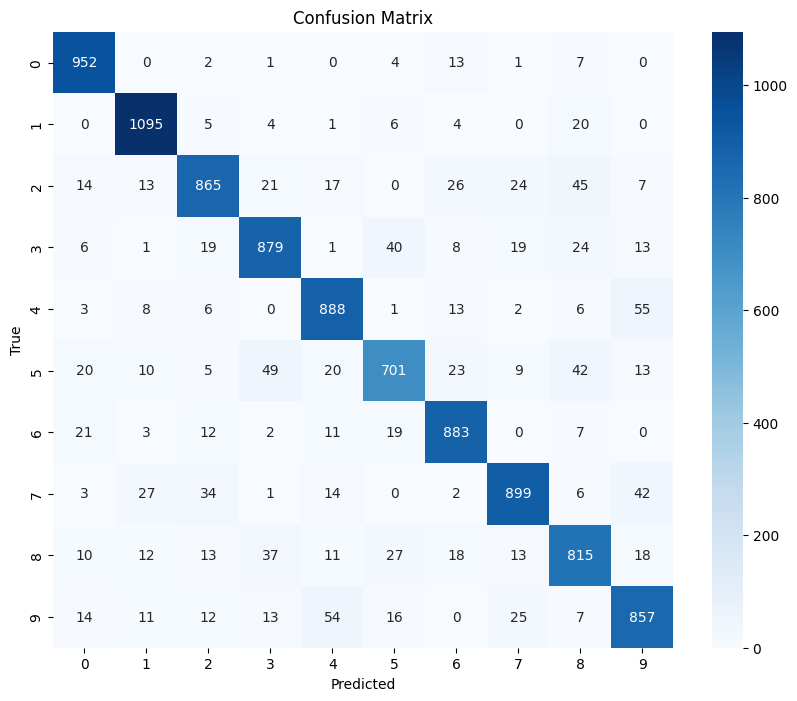

In [18]:
def plot_confusion_matrix(model, test_loader):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, test_loader)

## Improving the Model with a Hidden Layer

Now let's add a hidden layer to improve performance. This creates a proper neural network with multiple layers.

In [19]:
class ImprovedNN(nn.Module):
    def __init__(self, hidden_size=128):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)  # First layer
        self.fc2 = nn.Linear(hidden_size, 10)        # Output layer
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)            # First layer
        x = self.fc2(x)            # Output layer (no activation yet)
        return x

# Create improved model
model = ImprovedNN(hidden_size=128).to(device)

# Setup optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

ImprovedNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Total parameters: 101,770


Epoch 1/1: 100%|██████████| 1875/1875 [00:02<00:00, 711.51it/s, loss=0.7978, acc=82.29%]


Epoch 1: Loss = 0.7782, Accuracy = 82.29%
Test Accuracy: 89.42%


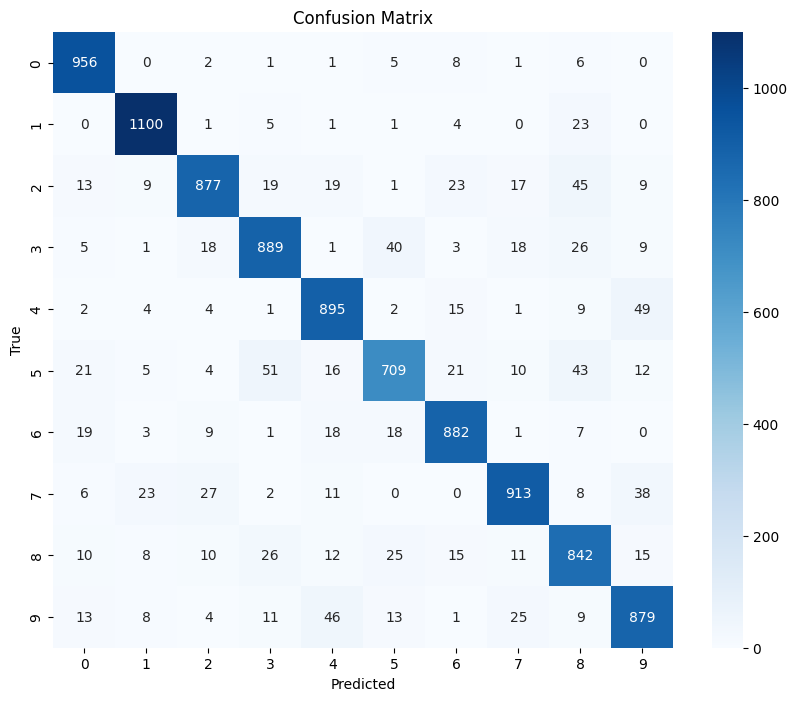

In [20]:
# Train the improved model
train_model(model, train_loader, criterion, optimizer, epochs=1)

# Evaluate
evaluate_model(model, test_loader)

# Plot confusion matrix
plot_confusion_matrix(model, test_loader)

## Experimenting with Neural Network Hyperparameters

**Questions to explore:**

* What happens when you add more layers?
* What happens when you use smaller hidden layers?
* What happens when you use larger hidden layers?
* What happens when you add `nn.ReLU()` activation after the first layer?

Try it below!

### Adding ReLU Activation

Let's add a non-linear activation function (ReLU) after the hidden layer. This allows the network to learn more complex patterns!

In [21]:
class NNWithReLU(nn.Module):
    def __init__(self, hidden_size=128):
        super(NNWithReLU, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.relu = nn.ReLU()  # Non-linear activation!
        self.fc2 = nn.Linear(hidden_size, 10)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)            # First layer
        x = self.relu(x)           # Activation function
        x = self.fc2(x)            # Output layer
        return x

# Create model with ReLU
model = NNWithReLU(hidden_size=128).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

NNWithReLU(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Total parameters: 101,770


Epoch 1/1: 100%|██████████| 1875/1875 [00:02<00:00, 720.65it/s, loss=0.8947, acc=80.90%]


Epoch 1: Loss = 0.8675, Accuracy = 80.90%
Test Accuracy: 89.04%


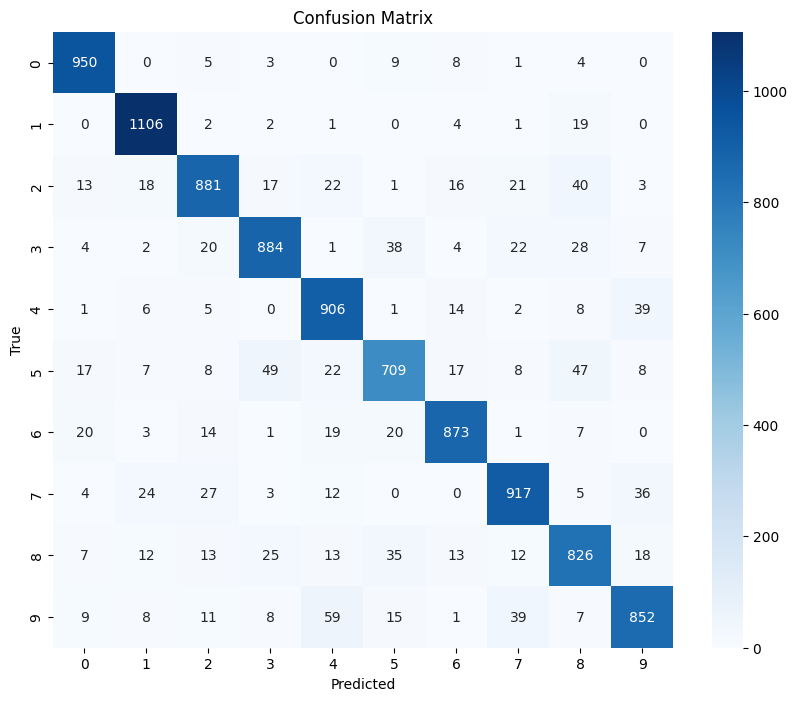

In [22]:
# Train model with ReLU
train_model(model, train_loader, criterion, optimizer, epochs=1)

# Evaluate
evaluate_model(model, test_loader)

# Plot confusion matrix
plot_confusion_matrix(model, test_loader)

## Your Turn!

Now it's your turn! Do whatever you want in an attempt to increase the accuracy.

You can check the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html), but I won't help you. Just try to do your best by yourself.

**Ideas to try:**
- Add more hidden layers
- Change the hidden layer size
- Try different activation functions (ReLU, LeakyReLU, Tanh)
- Add dropout: `nn.Dropout(0.2)`
- Change the learning rate
- Train for more epochs
- Try a different optimizer (Adam, RMSprop)

In [63]:
# Your custom model here!
class CustomNN(nn.Module):
    def __init__(self):
        super(CustomNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)  # Try different sizes!
        self.relu = nn.Tanh()
        self.fc2 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Create your custom model
model = CustomNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.3)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

CustomNN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu): Tanh()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

Total parameters: 535,818


Epoch 1/5: 100%|██████████| 1875/1875 [00:03<00:00, 582.33it/s, loss=0.4040, acc=87.89%]


Epoch 1: Loss = 0.4036, Accuracy = 87.89%


Epoch 2/5: 100%|██████████| 1875/1875 [00:03<00:00, 568.08it/s, loss=0.2042, acc=94.11%]


Epoch 2: Loss = 0.1986, Accuracy = 94.11%


Epoch 3/5: 100%|██████████| 1875/1875 [00:03<00:00, 595.36it/s, loss=0.1501, acc=95.66%]


Epoch 3: Loss = 0.1461, Accuracy = 95.66%


Epoch 4/5: 100%|██████████| 1875/1875 [00:03<00:00, 617.14it/s, loss=0.1207, acc=96.39%]


Epoch 4: Loss = 0.1188, Accuracy = 96.39%


Epoch 5/5: 100%|██████████| 1875/1875 [00:03<00:00, 592.45it/s, loss=0.1055, acc=96.91%]


Epoch 5: Loss = 0.1040, Accuracy = 96.91%
Test Accuracy: 96.04%


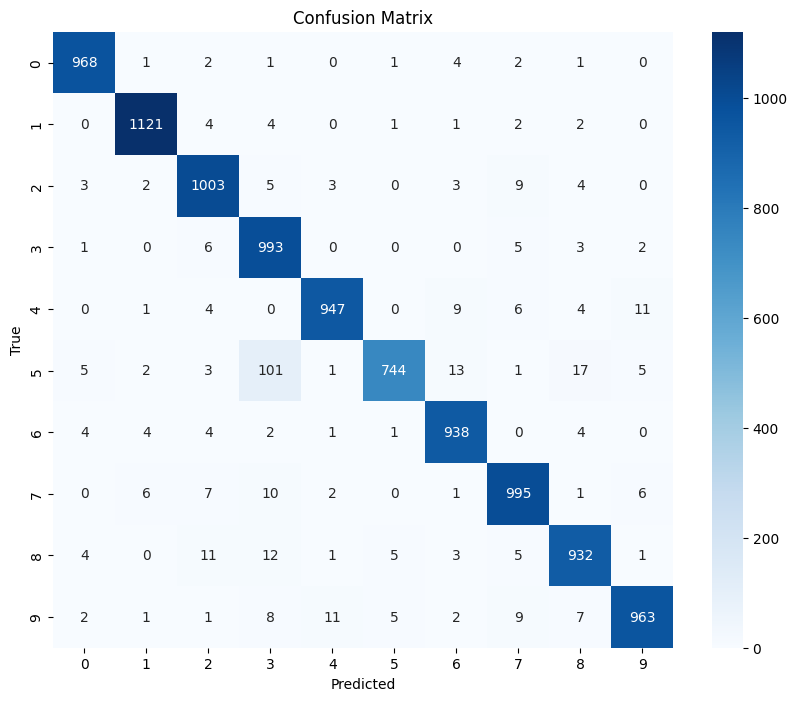

In [64]:
# Train your custom model
train_model(model, train_loader, criterion, optimizer, epochs=5)

# Evaluate
evaluate_model(model, test_loader)

# Plot confusion matrix
plot_confusion_matrix(model, test_loader)

## Summary

In this lab, you learned:

- ✅ How to load the MNIST dataset in PyTorch
- ✅ How to build neural networks using `nn.Module`
- ✅ How to define layers (Linear/Dense layers)
- ✅ How to set up loss functions and optimizers
- ✅ How to write a training loop
- ✅ How to evaluate model performance
- ✅ How to visualize results with confusion matrices
- ✅ The importance of activation functions (ReLU)
- ✅ How hyperparameters affect model performance

### Next Steps

- Experiment with different architectures
- Try training for multiple epochs
- Learn about convolutional layers (upcoming classes)
- Explore data augmentation
- Try other datasets